# GefCOM 2014 Forecasting Competition

In this tutorial, we show how to set up and train an WaveNet-based regression model with the deep4cast package. The dataset we're using is from the GEFCom2014 forecasting competition and involved hourly energy load forecasting.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import scale, FunctionTransformer
from sklearn.pipeline import make_pipeline

from deep4cast.forecasters import Forecaster
import deep4cast.models as models
import deep4cast.custom_metrics as metrics
import deep4cast.utils as utils

%matplotlib inline

Using TensorFlow backend.


## Data preparation

This is the first crucial step in building a solid forecaster. We need to prepare the data
set so that the numerics of our algorithms can work as efficianlty as possible.

In [2]:
# For our forecaster, we are going to have a lookback window called 'lag' and a horizon window
# called 'horizon' for which we will forecast.
lag = 48  # measured in hours
horizon = 24 # measured in hours

# Loading the dataset and dropping unncecessary columns
df = pd.read_pickle('data/GEFCom2014-E_processed.pkl')
df = df[-2000:]
data = df.drop(['time', 'month', 'day', 'hour'], axis=1)
data = data.dropna()

# We have real-valued and categorial features and we need to make sure that we do the data 
# preparation for them correctly
real_values = ['load', 'temperature']
categorical = list(set(data.columns).difference(set(real_values)))

# Let's create shifted categorical feature to include information about the future's holiday 
# structure. This will make it easier for our model to do predictions on holidays
shifted = data[categorical].shift(-horizon)
shifted = shifted.rename(columns={column:column + '_shifted' for column in shifted.columns})
data = pd.concat([data, shifted], axis=1)

# Format data into numpy array
data = np.expand_dims(data.values, 0)

# Now we need to sequentialize the training and testing dataset
X_train, y_train = utils.sequentialize(data[:,:-horizon,:], lag, horizon, targets=[0])
X_test, y_test = utils.sequentialize(data[:,-horizon-lag:,:], lag, horizon, targets=[0])

# Transform the datasets to log-scale
X_train = utils.transform(X_train, np.log1p, targets=[0])
X_test = utils.transform(X_test, np.log1p, targets=[0])

# Rescale the datasets so that the neural networks can be fitted properly and stably
scaler = utils.VectorScaler(targets=[0, 1])
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

The time series below show hourly energy load data and hourly temperature data. We can use the temperature data as covariate for predicting the hourly load data into the future.

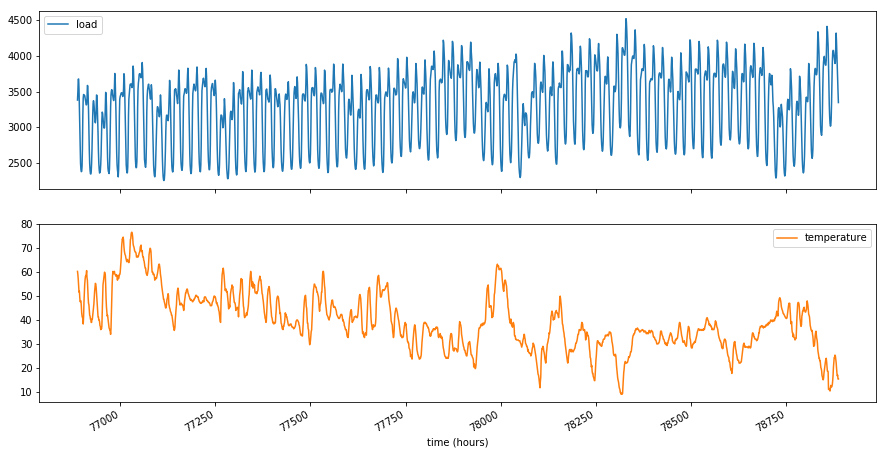

In [3]:
# Let plot the data
df[['load', 'temperature']].plot(subplots=True, figsize=(15, 8))
plt.xlabel('time (hours)')
plt.show()

# Modeling

Before we can fit a time series model, we need to specify a neural network topology that is suitable for this kind of time series. In this example, we opt for a WaveNet like topology that consists of stacked causal convolutional layers with residual connections.

In [4]:
model = models.WaveNet(filters=64, num_layers=4)

In [5]:
lag = 2*horizon

forecaster = Forecaster(
    model,
    lag=lag,  # This is the number of time steps used to predict the future for each data point
    horizon=horizon,  # This is how many time steps into the future we want to produce
    lr=0.001,  # This is the learning rate for the optimizer
    epochs=10
)

TypeError: unsupported callable

In [15]:
forecaster.fit(data_train, targets=[0], verbose=1)

Epoch 1/8
39905/39905 [==============================] - 52s 1ms/step - loss: 0.2332
Epoch 2/8
39905/39905 [==============================] - 49s 1ms/step - loss: -1.1459
Epoch 3/8
39905/39905 [==============================] - 49s 1ms/step - loss: -1.6946
Epoch 4/8
39905/39905 [==============================] - 50s 1ms/step - loss: -2.0759
Epoch 5/8
39905/39905 [==============================] - 50s 1ms/step - loss: -2.3657
Epoch 6/8
39905/39905 [==============================] - 49s 1ms/step - loss: -2.5536
Epoch 7/8
39905/39905 [==============================] - 50s 1ms/step - loss: -2.6927
Epoch 8/8
39905/39905 [==============================] - 50s 1ms/step - loss: -2.8085


We prevent overfitting of the model using early stopping when the validation set error stops improving. We use a patience parameters in the forecaster object to control when to stop.

Text(0,0.5,"['Loss']")

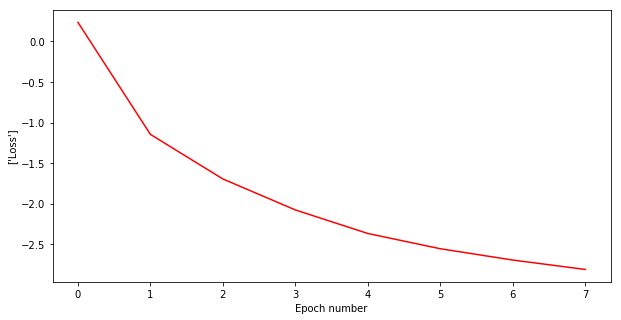

In [16]:
plt.figure(figsize=(10,5))
plt.plot(forecaster.history.epoch, forecaster.history.history['loss'], 'r')
plt.xlabel('Epoch number')
plt.ylabel(['Loss'])

# Evaluation

In [17]:
samples = forecaster.predict(data=data_train, n_samples=1000)
samples = samples.squeeze()
samples = samples*load_std + load_mu
prediction_mean = np.mean(samples, axis=0)
prediction_lq = np.percentile(samples, q=5, axis=0)
prediction_uq = np.percentile(samples, q=95, axis=0)

One meaningful way of evaluating model performance is the Mean Absolute Percentage Error (MAPE), which we use here to see how well we are doing.

SMAPE: 9.96%
Pinball Score: 31.35
Std. SMAPE: 56.54%
Coverage: 


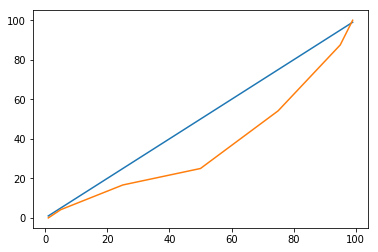

In [18]:
print('SMAPE: {}%'.format(round(metrics.smape(prediction_mean, data_test[0,:,0]), 2)))

cov, perc = metrics.coverage(samples, data_test[0,:,0])
pinball = metrics.pinball_loss(samples, data_test[0,:,0])
std_smape = metrics.std_smape(samples, data_test[0,:,0])

print('Pinball Score: {}'.format(pinball))
print('Std. SMAPE: {}%'.format(std_smape))
print('Coverage: ')
plt.plot(perc, perc)
plt.plot(perc, cov)

Lastly, we can check how our predictions compare with the data.

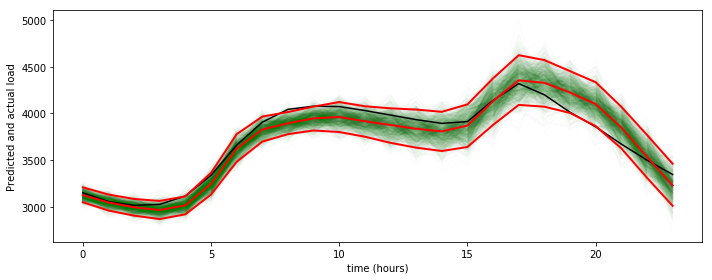

In [19]:
# We're printing the test set data and the predictions for the load data
plt.figure(figsize=(10, 4))
plt.plot(samples.T, 'g', alpha=0.01)
plt.plot(data_test[0,:,0].T, 'k')
plt.plot(prediction_mean, 'r', linewidth=2)
plt.plot(prediction_lq, 'r', linewidth=2)
plt.plot(prediction_uq, 'r', linewidth=2)
plt.xlabel('time (hours)')
plt.ylabel('Predicted and actual load')
plt.tight_layout()